In [6]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [19]:
# daa = load_data('2018092_20180930')
# format1_path = 'data_format1_' + '20181007_20181014' + '.h5'
# f1_data = pd.HDFStore(os.path.join(data_root, format1_path))

In [2]:
data_root = '../../data/'
root = './'
model_folder = './models'

In [3]:
'''
format1: {currency_type: {time: ['close', 'high', 'low', 'open', 'volume']}}
format2: {time: {currency_type: ['close', 'high', 'low', 'open', 'volume']}}
'''

def load_data(date_list):
    data_root = '../../data/'
    currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    curr_info = dict.fromkeys(currencies)
    
    date_list = date_list if type(date_list) is list else [date_list]
    
    for date in date_list:
        print(f'load data from {date}')
        format1_path = 'data_format1_' + date + '.h5'
        f1_data = pd.HDFStore(os.path.join(data_root, format1_path))
        
#         if date == '20181008_20181014':
#             for curr in ['/data\\BCH-USD', '/data\\BTC-USD', '/data\\ETH-USD', '/data\\LTC-USD']:
#                 if curr_info[curr] is None:
#                     curr_info[curr] = f1_data[curr]
#                 else:
#                     curr_info[curr] = curr_info[curr].append(f1_data[curr])
#         else:
        for curr in currencies:
            if curr_info[curr] is None:
                curr_info[curr] = f1_data[curr]
            else:
                curr_info[curr] = curr_info[curr].append(f1_data[curr])
        f1_data.close()
        
    for key, item in curr_info.items():
        curr_info[key]['volume_minmax'] = MinMaxScaler().fit_transform(item[['volume']]).reshape(1,-1)[0]        
        curr_info[key]['avg'] = item[['close', 'high', 'low', 'open']].mean(axis=1)
        
    return curr_info # {curr_name: cur_df}

def load_h5(date):
    data_root = './drive/Colab Notebooks/data/'
    format1_path = 'data_format1_' + date + '.h5'
    format2_path = 'data_format2_' + date + '.h5'
    
    f1_data = h5py.File(os.path.join(data_root, format1_path), 'r')
    f2_data = h5py.File(os.path.join(data_root, format2_path), 'r')
    
    return f1_data, f2_data
    

In [0]:
# f1, f2 = load_h5('201808')
# f1 = load_data(['201807', '201808'])
# f1['BCH-USD']
# f1, f2 = load_h5('201808')
# f2['2018-08-01 00:00:00'][]


array([[7.76960000e+02, 7.76960000e+02, 7.76280000e+02, 7.76280000e+02,
        1.13108299e+01],
       [7.73077000e+03, 7.73191000e+03, 7.72727000e+03, 7.72728000e+03,
        3.50382689e+00],
       [4.32950000e+02, 4.32950000e+02, 4.32360000e+02, 4.32360000e+02,
        1.49934641e+02],
       [7.90200000e+01, 7.90700000e+01, 7.88800000e+01, 7.88800000e+01,
        3.04508209e+02]])

In [0]:
# f1['LTC-USD'].head()
# minmax = MinMaxScaler().fit_transform(f1['LTC-USD'][['volume']])
# minmax
# for key, item in f1.items():
#     f1[key]['volume_minmax'] = MinMaxScaler().fit_transform(f1[key][['volume']]).reshape(1,-1)[0]
# len(f1['LTC-USD'].columns)

7

,close,high,low,open,volume,avg,volume_minmax
time,,,,,,,
2018-08-01 00:00:00,79.02,79.07,78.88,78.88,304.508209,78.9625,0.031037
2018-08-01 00:01:00,79.01,79.02,79.00,79.02,9.220407,79.0125,0.000940
2018-08-01 00:02:00,79.00,79.01,79.00,79.01,41.986554,79.0050,0.004280
2018-08-01 00:03:00,78.86,79.00,78.85,79.00,315.791794,78.9275,0.032187
2018-08-01 00:04:00,78.82,78.86,78.82,78.85,186.512855,78.8375,0.019010


In [0]:
# print(list(f1.keys()))
# print(list(f2.keys()))
# f2['2018-08-01 00:00:00'][:]
# f1['LTC-USD'].head(10)

,close,high,low,open,volume,avg,volume_minmax
time,,,,,,,
2018-08-01 00:00:00,79.02,79.07,78.88,78.88,304.508209,78.9625,0.031037
2018-08-01 00:01:00,79.01,79.02,79.00,79.02,9.220407,79.0125,0.000940
2018-08-01 00:02:00,79.00,79.01,79.00,79.01,41.986554,79.0050,0.004280
2018-08-01 00:03:00,78.86,79.00,78.85,79.00,315.791794,78.9275,0.032187
2018-08-01 00:04:00,78.82,78.86,78.82,78.85,186.512855,78.8375,0.019010
2018-08-01 00:05:00,78.87,78.87,78.82,78.82,369.017066,78.8450,0.037612
2018-08-01 00:06:00,78.86,78.87,78.86,78.87,17.726241,78.8650,0.001807
2018-08-01 00:07:00,78.87,78.87,78.86,78.86,35.126820,78.8650,0.003580
2018-08-01 00:08:00,78.87,78.87,78.86,78.86,19.133186,78.8650,0.001950


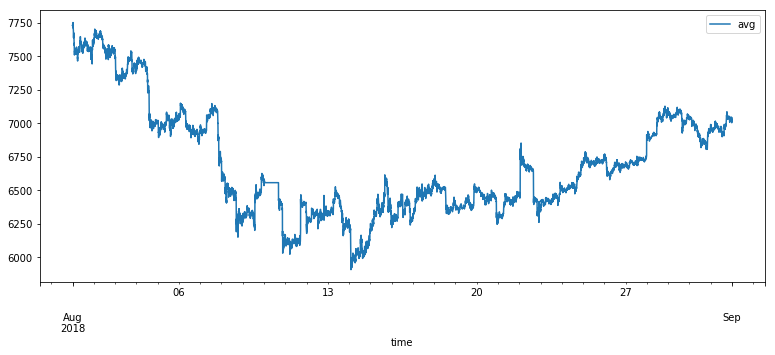

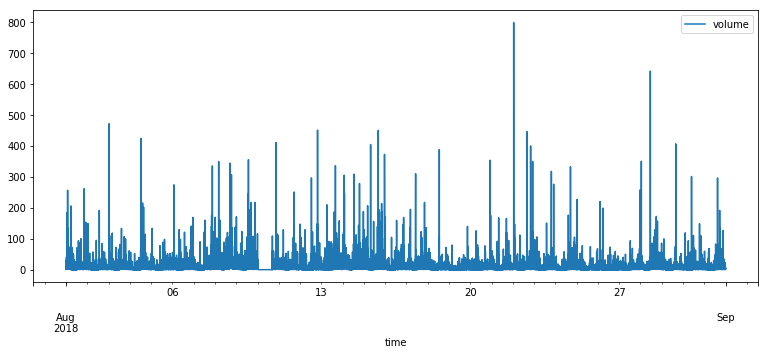

In [0]:
# curr_data = load_data('201808')
# # curr_data['BTC-USD'].loc['open', 'close', 'high', 'low']
# curr_data['BTC-USD'][['avg']].plot(figsize=(13, 5))
# curr_data['BTC-USD'][['volume']].plot(figsize=(13, 5))

## Modeling

In [8]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, Flatten

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [9]:
def build_model(dims_per_layer):
    loss_func = 'mse'
    optimiser_func = 'rmsprop'
    
    rnn_model = Sequential()

    # Plan A
    rnn_model.add(LSTM(
                input_dim=dims_per_layer[0],
                output_dim=50,
                return_sequences=True))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(100, return_sequences=False))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(Dense(output_dim=1))
    rnn_model.add(Activation('tanh'))
    
#    # Plan B
#     rnn_model.add(LSTM(input_dim=dims_per_layer[0], output_dim=dims_per_layer[1], return_sequences=True))
#     rnn_model.add(Dropout(0.1))
#     rnn_model.add(LSTM(output_dim=dims_per_layer[2], return_sequences=True))
#     rnn_model.add(Dropout(0.1))
    
#     rnn_model.add(Flatten())
    
#     rnn_model.add(Dense(output_dim=dims_per_layer[3]))
#     rnn_model.add(Activation('tanh'))
    
    rnn_model.compile(loss=loss_func, optimizer=optimiser_func)
    return rnn_model

def train_model(model_name, train_x, train_y, epoches=100, batch_size=4):
    
    model = build_model([train_x.shape[-1], 128, 64, 1])
    model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, verbose=2)
    
#     joblib.dump(model, os.path.join(root, f'./{model_name}.joblib'))
    return model
    

def split_train_xy(df, window_x, window_y, stride=1):
    train_x = []
    train_y = []
    i = 0
    while(i+window_x+window_y < len(df)):
        train_x = train_x.append((df[i:(i+window_x)][['open', 'close', 'high', 'low', 'volume_minmax']]).values)
#         train_y.append(df[(i+window_x):(i+window_x+window_y)][['avg']])
        train_y = train_y.append((df.iloc[(i+window_x+window_y)][['avg']]).values)
        
        i += stride
                
    return train_x, train_y

# # build model & prepare train test data set
# def create_dataset(dataset, look_back=1, look_forward=1):
    
# 	data_x = []
#     data_y = []
#     i = 0
#     while i <= len(dataset)-look_back-look_forward-1:
# 		x = dataset[i:(i+look_back), 0]
# 		data_x.append(x)
#         y = dataset[i + look_back+look_forward, 0] - dataset[i + look_back, 0]
# 		data_y.append(y)
#         i += look_forward
# 	return np.array(data_x), np.array(data_y)

In [10]:
def create_dataset(dataset, look_back=1, look_forward=1):
    data_x = []
    data_y = []
    i = 0
    while i < len(dataset)-look_back-look_forward-1:
        x = dataset[i:(i+look_back), 0]
        data_x.append(x)
        y = dataset[i+look_back+look_forward, 0] - dataset[i+look_back, 0]
        data_y.append(y)
        i += look_forward
        
    return np.array(data_x), np.array(data_y)

In [9]:
# train_x = pd.DataFrame()
# train_x = train_x.append(data['LTC-USD'][0:30][['open', 'close', 'high', 'low', 'volume_minmax']])

In [10]:
data = load_data('201808')


data_ltc = data['LTC-USD'][['avg']]
train_size = int(len(data_ltc) * 0.8)
train_ltc, test_ltc = data_ltc.values[0:train_size, :], data_ltc.values[train_size:len(data_ltc), :]

look_back = 1
train_ltc_x, train_ltc_y = create_dataset(train_ltc, look_back)
test_ltc_x, test_ltc_y = create_dataset(test_ltc, look_back)
# minmaxscaler precessing

load data from 201808


In [0]:
# train_ltc_x.shape

(35710, 1)

In [0]:
train_ltc_x = np.reshape(train_ltc_x, (train_ltc_x.shape[0], 1, train_ltc_x.shape[1]))
test_ltc_x = np.reshape(test_ltc_x, (test_ltc_x.shape[0], 1, test_ltc_x.shape[1]))

# ltc_model = train_model('ltc_model', x_train, y_train)

In [0]:
train_ltc_x.shape

(35710, 1, 1)

In [0]:
model_ltc = train_model('model_ltc', train_ltc_x, train_ltc_y)

In [0]:
train_ltc_predict = model_ltc.predict(train_ltc_x)
test_ltc_predict = model_ltc.predict(test_ltc_x)

In [0]:
# model_ltc.history

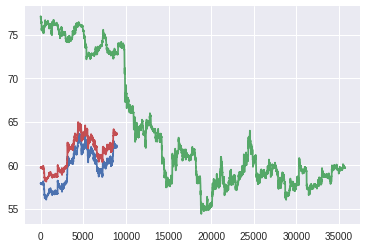

In [0]:
# shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
plt.plot(test_ltc_y) #red
plt.plot(train_ltc_predict)
plt.plot(test_ltc_predict) # green
plt.show()


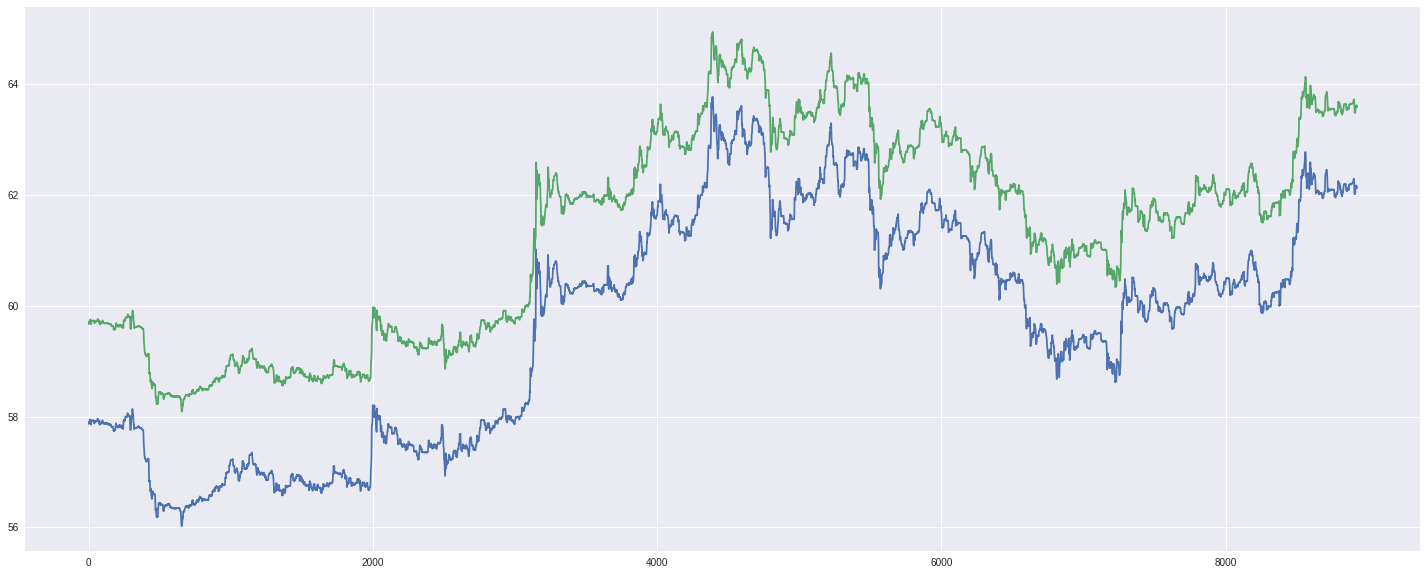

In [0]:
plt.figure(figsize=(25,10))
plt.plot(test_ltc_y) 
plt.plot(test_ltc_predict)
plt.show()

In [25]:
## Increasing Window size

currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

date_list = ['20180909_20180916', '20180916_20180923', '20180923_20180930', '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028', '20181028_20181104', '20181104_20181111', '20181111_20181118']
data = load_data(date_list)


load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111
load data from 20181111_20181118


In [13]:

look_back = 120
look_forward = 60

models = {}

for curr in currencies:
    print(f'{curr} data processing')
    data_curr = data[curr][['avg']]
    train_x, train_y = create_dataset(data_curr.values, look_back, look_forward)
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    print(train_x.shape)
    
    print(f'{curr} model training')
    model_curr = train_model(f'{curr} model', train_x, train_y)
    models[curr] = model_curr
    joblib.dump(model_curr, os.path.join(root, f'model_{curr.lower()}.joblib'))

BCH-USD data processing
(1677, 1, 120)
BCH-USD model training


TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [65]:
currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

date_list = ['20180901_20180909', '20180909_20180916', '20180916_20180923', '20180923_20180930', '20180930_20181007', '20181007_20181014', '20181014_20181021', '20181021_20181028', '20181028_20181104', '20181104_20181111']
data = load_data(date_list)

load data from 20180901_20180909
load data from 20180909_20180916
load data from 20180916_20180923
load data from 20180923_20180930
load data from 20180930_20181007
load data from 20181007_20181014
load data from 20181014_20181021
load data from 20181021_20181028
load data from 20181028_20181104
load data from 20181104_20181111


In [26]:
li = []
for i in currencies:
    li.append(joblib.load(os.path.join(root, f'model_{curr.lower()}.joblib')))

FileNotFoundError: [Errno 2] No such file or directory: './model_bch-usd.joblib'

In [27]:
i = 0
for m in li:
    m.save(os.path.join(root, f'model_{currencies[i].lower()}.h5'))
    i+=1

In [11]:
m = build_model([120])
m.load_weights(os.path.join(model_folder, 'model_bch_weight.h5'))

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.

In [17]:
import keras
print(keras.__version__)

2.2.4
